In [2]:

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pydicom
import os
import subprocess
from IPython.display import update_display
PATH = "/mnt/d/Datasets/Vindr-Mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/"
imgPATH = PATH + "images/"
ROI_PATH = '/mnt/d/Datasets/Vindr-Mammo/ROI/'
benign_roi_path = PATH + "ROI/benign/"
malignant_roi_path = PATH + "ROI/malignant/"
fullimg_benign_path = PATH + "fullimg/benign/"
fullimg_malignant_path = PATH + "fullimg/malignant/"
image_size=300
output_size=300
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [5]:
for dirName, subdirList, fileList in os.walk(imgPATH):
    for fname in fileList:
        print(dirName)
        if fname.endswith('.dicom'):
            dcm_path = dirName+'/'+fname
            img_path = dirName+'/'+fname.replace('.dicom','.png')
            subprocess.Popen(['convert',dcm_path,img_path]).wait()

/mnt/d/Datasets/Vindr-Mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images/0025a5dc99fd5c742026f0b2b030d3e9
/mnt/d/Datasets/Vindr-Mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images/0025a5dc99fd5c742026f0b2b030d3e9
/mnt/d/Datasets/Vindr-Mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images/0025a5dc99fd5c742026f0b2b030d3e9
/mnt/d/Datasets/Vindr-Mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images/0025a5dc99fd5c742026f0b2b030d3e9
/mnt/d/Datasets/Vindr-Mammo/vindr-mammo-a-large-scale-benchmark-dataset-for-computer-aided-detection-and-diagnosis-in-full-field-digital-mammography-1.0.0/images/0028fb2c7f0b3a5cb9a80cb0e1cdbb91
/mnt/d/Datasets/Vindr-Mam

In [3]:
csvdata = pd.read_csv(PATH + "finding_annotations.csv")
metadata = pd.read_csv(PATH + "metadata.csv")

In [4]:
category = csvdata.finding_birads.to_numpy()
img_id= csvdata.image_id.to_numpy()
series = csvdata.series_id.to_numpy()
mask_x_min = csvdata.xmin.to_numpy()
mask_y_min = csvdata.ymin.to_numpy()
mask_x_max = csvdata.xmax.to_numpy()
mask_y_max = csvdata.ymax.to_numpy()
view = csvdata.view_position.to_numpy()
side = csvdata.laterality.to_numpy()
filename = csvdata.study_id.to_numpy()
tran_test_split = csvdata.split.to_numpy()
height = csvdata.height.to_numpy()
width = csvdata.width.to_numpy()
finding_category = csvdata.finding_categories.to_numpy()

In [5]:
meta_img_id = metadata.SOP_Instance_UID.to_numpy()
monochrome = metadata.Photometric_Interpretation.to_numpy()

In [50]:
# def read_monochrome1:

def ROI(image_path,img_h,img_w,xmin,xmax,ymin,ymax,save_path,size,monochrome='2'):

    data = pydicom.dcmread(image_path)
    data = data.pixel_array.astype(float)
    data = (np.maximum(data,0)/data.max())*255.0
    # data = np.interp(data,[-32768,32768],[0,255])
    data = np.uint8(data)
    if xmin<0: xmin=0
    if xmax>img_w: xmax=img_w
    if ymin<0: ymin=0
    if ymax>img_h: ymax=img_h
    data = data[int(ymin):int(ymax),int(xmin):int(xmax)]
    if monochrome == 1:
        data = np.invert(data)
    data = cv2.medianBlur(data,3)
    data = clahe.apply(data)
    data = cv2.resize(data,(size,size))
    cv2.imwrite(save_path,data)



In [51]:
Progress_display = display("0% completed",display_id="Progress_display")
for i,x in enumerate(category):
    if str(x) != "nan" and finding_category[i] != "['No Finding']":
        image_path=str(imgPATH+filename[i]+'/'+img_id[i]+".dicom")
        save_path = filename[i] + "_" + view[i] + "_" + side[i] + ".png"
        if monochrome[np.where(meta_img_id==img_id[i])] == 'MONOCHROME1':MONOCHROME = 1
        else:MONOCHROME = 2
        if x.split(" ")[1] == '3':
            if tran_test_split[i] =='training':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"train/benign/"+save_path),300,MONOCHROME)
            elif tran_test_split[i] =='test':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"test/benign/"+save_path),300,MONOCHROME)
            else:
                print("Error occured with image "+str(img_id[i]))
        elif x.split(" ")[1] == '4' or x.split(" ")[1] =='5':
            if tran_test_split[i] =='training':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"train/malignant/"+save_path),300,MONOCHROME)
            elif tran_test_split[i] =='test':
                ROI(image_path,height[i],width[i],mask_x_min[i],mask_x_max[i],mask_y_min[i],mask_y_max[i],str(ROI_PATH+"test/malignant/"+save_path),300,MONOCHROME)
            else:
                print("Error occured with image "+str(img_id[i])) 
        else:
            print("Error occured with image "+str(img_id[i]))
    update_display(str(int(i/len(category)*100))+"% completed",display_id="Progress_display")
update_display("completed",display_id="Progress_display")
    

'completed'

# Testing

In [36]:
np.where(img_id == "afa015c6fcf47f108939c6663af44990/523cdecbef6f4fa9ec4c49ead52846ba" )

(array([], dtype=int64),)

1.0

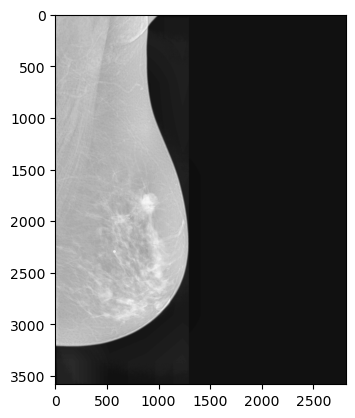

In [42]:
test = np.interp(data_dicom,[100,32768],[0,255])
test = np.uint8(test)
test = clahe.apply(test)
plt.imshow(test,cmap='gray')
data_dicom.min()

(3580, 2812)


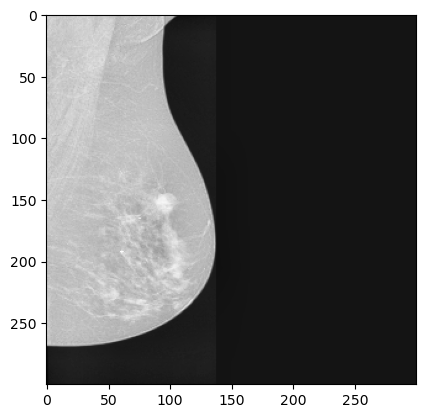

In [17]:
data_dicom = pydicom.dcmread(imgPATH+"afa015c6fcf47f108939c6663af44990/523cdecbef6f4fa9ec4c49ead52846ba.dicom")
# data = pydicom.dcmread(imgPATH+filename[0]+'/'+img_id[0]+".data")
data_dicom = data_dicom.pixel_array.astype(float)
data = (np.maximum(data_dicom,0)/data_dicom.max())*255.0

data = np.uint8(data)
# # # data = cv2.medianBlur(data,3)
# data = np.invert(data)
print(data.shape)

# data = data[int(mask_y_min[20140]):int(mask_y_max[20140]),int(mask_x_min[20140]):int(mask_x_max[20140])]
data = clahe.apply(data)
data = cv2.resize(data,(300,300))
plt.imshow(data, cmap="gray")

# cv2.imwrite(PATH+"test.png",data)